## CS6220: COVID-19 Vaccine Adverse Effects -- Data Visualization
### Team members: Alex Yang, Shuaizhen Li, Yiman Liu

In [790]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [727]:
import warnings
warnings.filterwarnings('ignore')

In [728]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, learning_curve, ShuffleSplit
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
matplotlib.style.use('ggplot')

### Import data

In [729]:
sym = pd.read_csv('./data/2021VAERSSYMPTOMS.csv')
vax = pd.read_csv('./data/2021VAERSVAX.csv')
info = pd.read_csv('./data/2021VAERSDATA.csv', encoding = "ISO-8859-1")

In [730]:
sym = sym.drop_duplicates(subset=['VAERS_ID'])
vax = vax.drop_duplicates(subset=['VAERS_ID'])
info = info.drop_duplicates(subset=['VAERS_ID'])

In [731]:
sym.head(1)

,VAERS_ID,SYMPTOM1,SYMPTOMVERSION1,SYMPTOM2,SYMPTOMVERSION2,SYMPTOM3,SYMPTOMVERSION3,SYMPTOM4,SYMPTOMVERSION4,SYMPTOM5,SYMPTOMVERSION5
0,916600,Dysphagia,23.1,Epiglottitis,23.1,NaN,NaN,NaN,NaN,NaN,NaN


In [732]:
vax.head(1)

,VAERS_ID,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME
0,916600,COVID19,MODERNA,037K20A,1,IM,LA,COVID19 (COVID19 (MODERNA))


In [733]:
info.head(1)

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES
0,916600,01/01/2021,TX,33.0,33.0,NaN,F,NaN,Right side of epiglottis swelled up and hinder...,NaN,...,None,None,NaN,NaN,2,01/01/2021,NaN,Y,NaN,Pcn and bee venom


### Drop unnecessary columns

In [734]:
sym = sym.drop(columns=['SYMPTOMVERSION1', 'SYMPTOMVERSION2', 'SYMPTOMVERSION3', 'SYMPTOMVERSION4', 'SYMPTOMVERSION5'])
sym = sym.replace(np.nan, 'unknown')
sym.head(1)

,VAERS_ID,SYMPTOM1,SYMPTOM2,SYMPTOM3,SYMPTOM4,SYMPTOM5
0,916600,Dysphagia,Epiglottitis,unknown,unknown,unknown


Drop unnecessary columns and remove instances that are not Covid-10 vaccines.

In [735]:
i = vax[(vax.VAX_TYPE != 'COVID19')].index
vax = vax.drop(i)
vax = vax.drop(columns=['VAX_LOT', 'VAX_ROUTE', 'VAX_SITE', 'VAX_TYPE', 'VAX_DOSE_SERIES', 'VAX_NAME'])
vax = vax.replace(np.nan, 'unknown')
vax.head(1)

,VAERS_ID,VAX_MANU
0,916600,MODERNA


In [736]:
info = info.drop(columns=['RECVDATE', 'STATE', 'CAGE_YR', 'CAGE_MO', 'RPT_DATE', 'SYMPTOM_TEXT', 'DATEDIED', 'ER_VISIT', 
                  'HOSPITAL', 'HOSPDAYS', 'X_STAY', 'RECOVD', 'VAX_DATE', 'ONSET_DATE', 'NUMDAYS', 'LAB_DATA', 
                  'V_ADMINBY', 'V_FUNDBY', 'SPLTTYPE', 'FORM_VERS', 'TODAYS_DATE', 'OFC_VISIT', 'ER_ED_VISIT',
                  'DIED', 'L_THREAT', 'DISABLE', 'PRIOR_VAX', 'BIRTH_DEFECT'])
info = info.replace(np.nan, 'unknown')
info.head(1)

,VAERS_ID,AGE_YRS,SEX,OTHER_MEDS,CUR_ILL,HISTORY,ALLERGIES
0,916600,33,F,None,None,None,Pcn and bee venom


### Merge symptoms into one column

In [739]:
sym['SYMPTOM'] = sym[sym.columns[1:]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)
sym.head(1)

,VAERS_ID,SYMPTOM1,SYMPTOM2,SYMPTOM3,SYMPTOM4,SYMPTOM5,SYMPTOM
0,916600,Dysphagia,Epiglottitis,unknown,unknown,unknown,"Dysphagia,Epiglottitis,unknown,unknown,unknown..."


### High frequent illness

In [743]:
list_history = ['hypothyroidism', 'rheumatoid', 'arthritis', 'insomnia', 'cholesterol', 'asthma', 'migraines', 'lymphoma',
        'diabetes', 'depression', 'obesity', 'anemia', 'dermatitis', 'dysmenorrhea', 'neuropathy', 'fibromyalgia',
        'disabilities', 'autism', 'prostate', 'gallstones']
count = [3579, 6113, 846, 3842, 1496, 902, 4564, 4302, 2107, 2049, 5008, 675, 
         2059, 2354, 4866, 2813, 2166, 962, 5707, 3000]
for i in range(len(count)):
    count[i] = count[i] / 34121

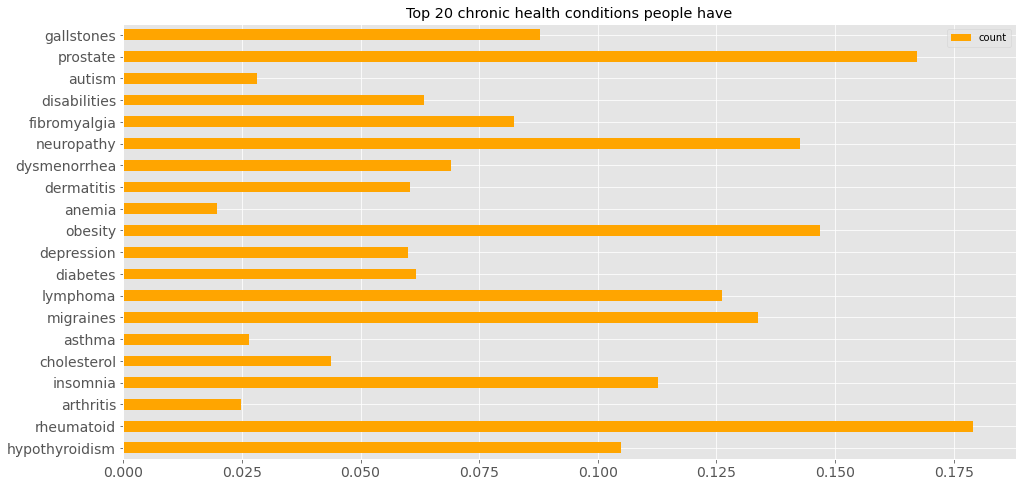

In [744]:
df = pd.DataFrame({'count': count}, index=list_history)
title = 'Top 20 chronic health conditions people have'
ax = df.plot.barh(figsize = (16,8), rot=0, title=title, fontsize = 14, color='orange')

In [745]:
list_medication = ['Synthroid', 'phenobarbital', 'hydroxychloroquine', 'famotidine', 'acetaminophen', 'propranolol', 'Zoloft',
         'lisinopril', 'crestor', 'protonix', 'melatonin', 'estradiol', 'topiramate', 'sumatriptan', 'multivitamin',
         'novolog', 'lantus', 'gabapentin', 'glusosamine', 'chondroitin']
count = [8488, 6975, 4473, 3594, 728, 7350, 9667, 5310, 2648, 7378,5660, 
         3425, 8805, 8399, 6148, 6467, 5012, 3947, 4085, 2271]
for i in range(len(count)):
    count[i] = count[i] / 34121

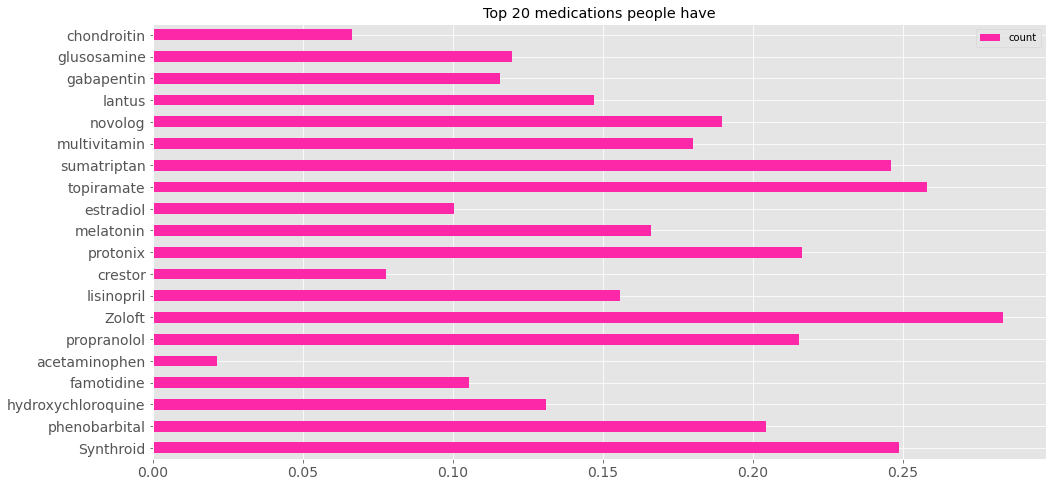

In [746]:
df = pd.DataFrame({'count': count}, index=list_medication)
title = 'Top 20 medications people have'
ax = df.plot.barh(figsize = (16,8), rot=0, title=title, fontsize = 14, color='#FC28A8')

In [747]:
list_allergy = ['bee', 'codeine', 'sulfa', 'shellfish', 'peanuts', 'soy', 'oysters', 'crab', 'lobster', 'penicillin',
                'eurythromyacin', 'Prozac', 'dust', 'mites', 'dairy', 'egg', 'seafood', 'antibiotics', 'milk', 'wheat']
count = [578, 1116, 4249, 4030, 3323, 4141, 3266, 1244, 2612, 3362, 1724, 
         3672, 1553, 2866, 1294, 1597, 3962, 359, 2842, 4826]
for i in range(len(count)):
    count[i] = count[i] / 34121

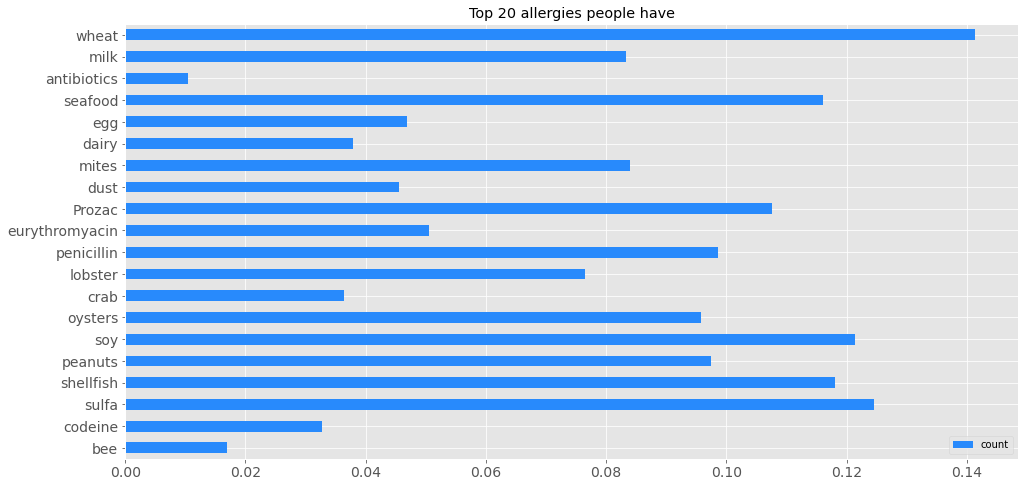

In [748]:
df = pd.DataFrame({'count': count}, index=list_allergy)
title = 'Top 20 allergies people have'
ax = df.plot.barh(figsize = (16,8), rot=0, title=title, fontsize = 14, color='#288AFC')

## World Vaccination Progress

In [753]:
data = pd.read_csv('./data/country_vaccinations.csv')

In [754]:
data.head(2)

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...


### Pre-process the data

In [755]:
data = data.drop(columns=['iso_code', 'daily_vaccinations_raw', 'people_vaccinated', 'people_vaccinated_per_hundred',
                         'daily_vaccinations_per_million', 'source_name', 'source_website'])

In [437]:
data.head(2)

,country,date,total_vaccinations,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_fully_vaccinated_per_hundred,vaccines
0,Afghanistan,2021-02-22,0.0,NaN,NaN,0.0,NaN,Oxford/AstraZeneca
1,Afghanistan,2021-02-23,NaN,NaN,1367.0,NaN,NaN,Oxford/AstraZeneca


In [756]:
b = data[(data['date'] == '2021-03-24')]
b.head(2)

,country,date,total_vaccinations,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_fully_vaccinated_per_hundred,vaccines
96,Albania,2021-03-24,53992.0,NaN,2946.0,1.88,NaN,Pfizer/BioNTech
192,Angola,2021-03-24,87022.0,NaN,6044.0,0.26,NaN,Oxford/AstraZeneca


In [757]:
c = data.groupby(['vaccines']).sum().sort_values(by=['daily_vaccinations'], ascending=False)
c.head(2)

,total_vaccinations,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_fully_vaccinated_per_hundred
vaccines,,,,,
"Johnson&Johnson, Moderna, Pfizer/BioNTech",4.278652e+09,1.292304e+09,123442260.0,1279.34,386.38
"Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac",5.142530e+08,0.000000e+00,74900499.0,35.73,0.00


In [758]:
vaccines = ['Moderna', 'Oxford/AstraZeneca', 'Pfizer/BioNTech', 'Sinopharm/Beijing', 'Sputnik V', 'Johnson&Johnson']
nums = [67377405, 101103830, 113541153, 33473587, 10177263, 41342725]

In [759]:
d = {'Vaccine':vaccines,'Count':nums}
res = pd.DataFrame(d, index=vaccines)
res

,Vaccine,Count
Moderna,Moderna,67377405
Oxford/AstraZeneca,Oxford/AstraZeneca,101103830
Pfizer/BioNTech,Pfizer/BioNTech,113541153
Sinopharm/Beijing,Sinopharm/Beijing,33473587
Sputnik V,Sputnik V,10177263
Johnson&Johnson,Johnson&Johnson,41342725


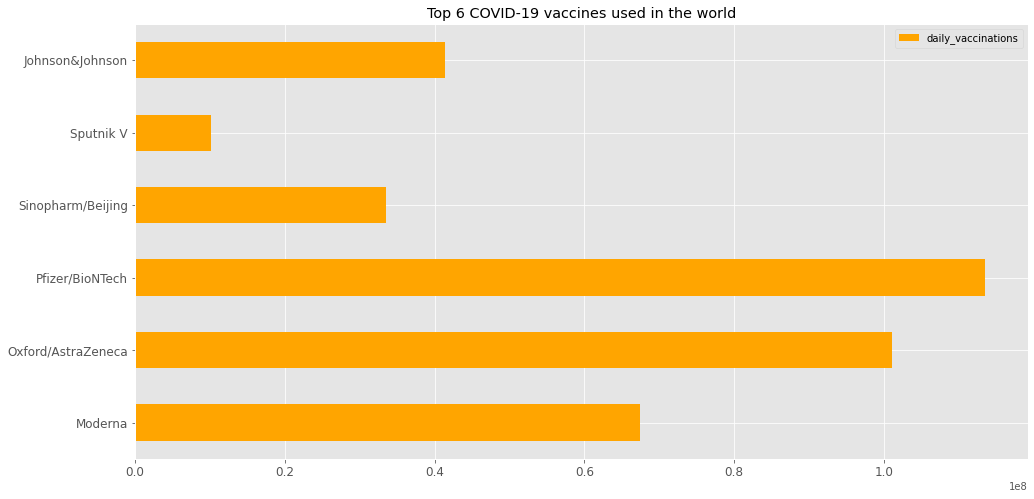

In [760]:
df = pd.DataFrame({'vaccine': ['Moderna', 'Oxford/AstraZeneca', 'Pfizer/BioNTech', 
                               'Sinopharm/Beijing', 'Sputnik V', 'Johnson&Johnson'],
                   'daily_vaccinations': [67377405, 101103830, 113541153, 33473587, 10177263, 41342725]},
                  index=['Moderna', 'Oxford/AstraZeneca', 'Pfizer/BioNTech', 
                         'Sinopharm/Beijing', 'Sputnik V', 'Johnson&Johnson'])
title = 'Top 6 COVID-19 vaccines used in the world'
ax = df.plot.barh(figsize = (16,8), rot=0, title=title, fontsize = 12, color='orange')

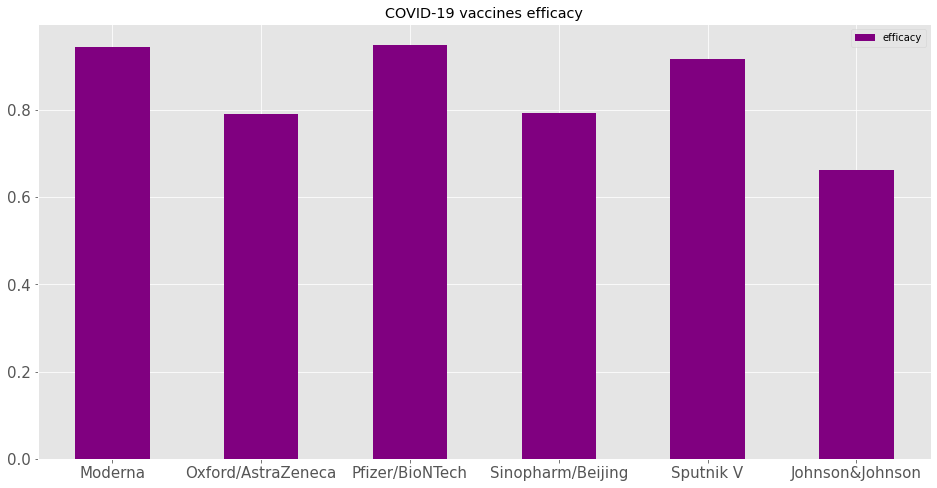

In [761]:
df = pd.DataFrame({'efficacy': [0.945, 0.79, 0.95, 0.7934, 0.916, 0.663]},
                  index=['Moderna', 'Oxford/AstraZeneca', 'Pfizer/BioNTech', 
                         'Sinopharm/Beijing', 'Sputnik V', 'Johnson&Johnson'])
title = 'COVID-19 vaccines efficacy'
ax = df.plot.bar(figsize = (16,8), rot=0, title=title, fontsize = 15, color='purple')

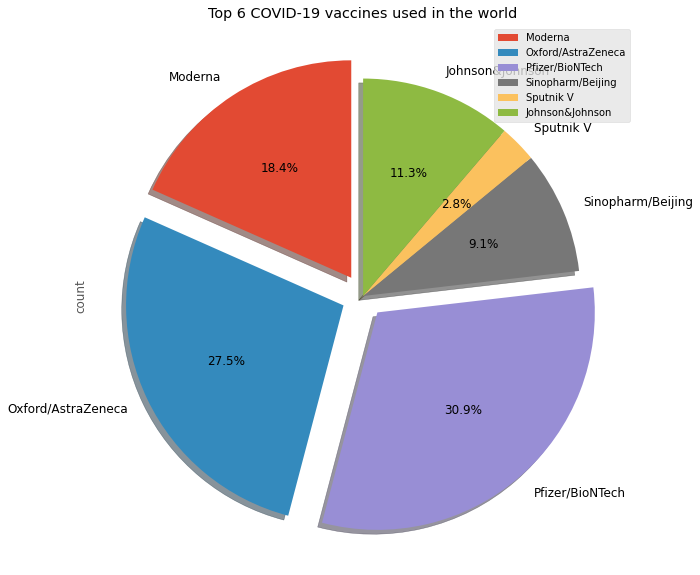

In [763]:
df = pd.DataFrame({'vaccine': ['Moderna', 'Oxford/AstraZeneca', 'Pfizer/BioNTech', 
                               'Sinopharm/Beijing', 'Sputnik V', 'Johnson&Johnson'],
                   'count': [67377405, 101103830, 113541153, 33473587, 10177263, 41342725]},
                  index=['Moderna', 'Oxford/AstraZeneca', 'Pfizer/BioNTech', 
                         'Sinopharm/Beijing', 'Sputnik V', 'Johnson&Johnson'])
explode =(0.1,0.1,0.1,0,0,0) 
title='Top 6 COVID-19 vaccines used in the world'
plot = df.plot.pie(y='count', figsize=(20, 10), explode=explode, startangle=90, autopct='%.1f%%', shadow = True,
                  title=title, fontsize=12)

In [764]:
data = data.dropna()
data.head(2)

,country,date,total_vaccinations,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_fully_vaccinated_per_hundred,vaccines
53,Albania,2021-02-09,1127.0,438.0,82.0,0.04,0.02,Pfizer/BioNTech
61,Albania,2021-02-17,1701.0,611.0,72.0,0.06,0.02,Pfizer/BioNTech


In [766]:
prev = ""
prevIdx = 0
for index, row in data.iterrows():
    if (row['country'] == prev):
        data = data.drop([prevIdx])
    prevIdx = index
    prev = row['country']

In [767]:
top_10 = data.groupby(['country']).max().sort_values(by=['total_vaccinations'], ascending=False).head(10)
top_10.head(2)

,date,total_vaccinations,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_fully_vaccinated_per_hundred,vaccines
country,,,,,,,
United States,2021-03-24,130473853.0,46365515.0,2490889.0,39.01,13.86,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
India,2021-03-24,53145709.0,8299171.0,2286065.0,3.85,0.60,"Covaxin, Oxford/AstraZeneca"


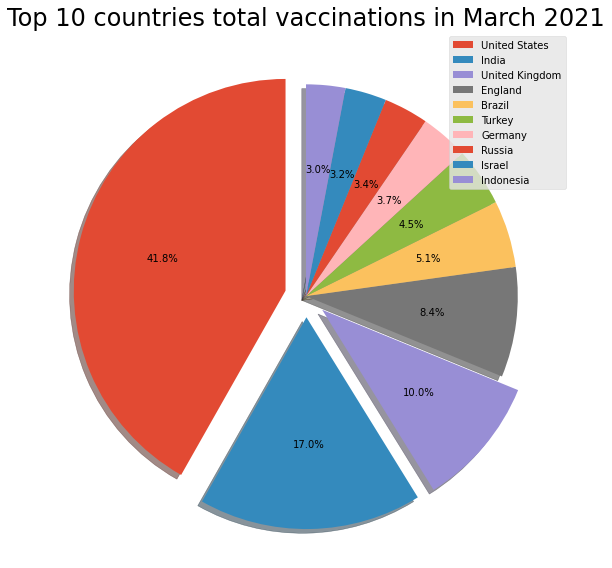

In [769]:
labels = top_10.index
explode =(0.1,0.1,0.1,0,0,0,0,0,0,0) 
fig, ax1 = plt.subplots(figsize = (16,8)) 
ax1.pie(top_10['total_vaccinations'], explode = explode, startangle=90, autopct='%.1f%%', shadow = True) 
plt.title('Top 10 countries total vaccinations in March 2021', fontsize = 24) 
ax1.legend(labels, loc = 'upper right') 
plt.tight_layout() 
plt.show()

In [770]:
top_10 = data.sort_values(by=['people_fully_vaccinated'], ascending=False).head(10)
top_10.head(1)

,country,date,total_vaccinations,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_fully_vaccinated_per_hundred,vaccines
7882,United States,2021-03-24,130473853.0,46365515.0,2490889.0,39.01,13.86,"Johnson&Johnson, Moderna, Pfizer/BioNTech"


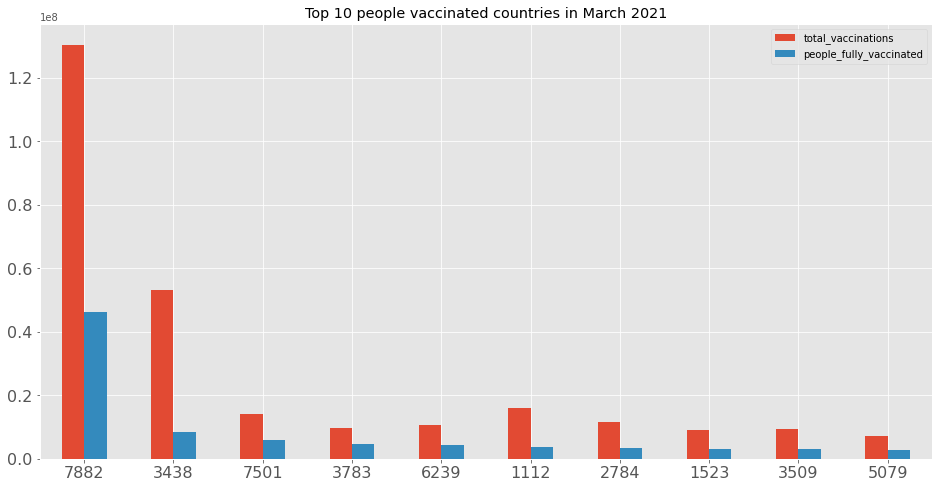

In [771]:
total = pd.Series(top_10['total_vaccinations']).array
people = pd.Series(top_10['people_fully_vaccinated']).array
index = top_10.index
df = pd.DataFrame({'total_vaccinations': total,
                   'people_fully_vaccinated': people}, index=index)
ax = df.plot.bar(figsize = (16,8), rot=0, title='Top 10 people vaccinated countries in March 2021', fontsize = 16)

## COVID-19 Data

In [772]:
data = pd.read_csv('./data/owid-covid-data.csv')

In [773]:
data.head(2)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


### Remove unnecessary columns

In [774]:
data = data.drop(columns=['iso_code','new_cases_smoothed', 'new_deaths_smoothed', 'total_cases_per_million', 
                         'new_cases_smoothed_per_million', 'total_deaths_per_million',
                         'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'icu_patients_per_million',
                         'weekly_icu_admissions', 'weekly_icu_admissions_per_million',
                         'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'new_tests', 
                          'total_tests_per_thousand', 'new_tests_smoothed', 
                          'new_tests_smoothed_per_thousand', 'tests_per_case', 'tests_units', 
                          'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred', 
                          'new_vaccinations_smoothed_per_million', 
                          'stringency_index', 'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
                         'male_smokers', 'life_expectancy', 'human_development_index'])
data.head(3)

,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,new_cases_per_million,reproduction_rate,icu_patients,...,people_fully_vaccinated_per_hundred,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,handwashing_facilities,hospital_beds_per_thousand
0,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,0.026,NaN,NaN,...,NaN,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,37.746,0.5
1,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,0.000,NaN,NaN,...,NaN,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,37.746,0.5
2,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,0.000,NaN,NaN,...,NaN,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,37.746,0.5


### Explore how vaccination affects the number of COVID-19 cases

In [775]:
b = data[(data['date'] >= '2021-01-01')]
us = us[(us['location'] == 'United States')]
us.dropna()
us.tail()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
74316,USA,North America,United States,2021-03-24,30011839.0,86947.0,57625.857,545409.0,1454.0,971.429,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926
74317,USA,North America,United States,2021-03-25,30079282.0,67443.0,58617.571,546967.0,1558.0,962.571,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926
74318,USA,North America,United States,2021-03-26,30156621.0,77339.0,60876.429,548088.0,1121.0,966.286,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926
74319,USA,North America,United States,2021-03-27,30218683.0,62062.0,61821.143,548829.0,741.0,961.143,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926
74320,USA,North America,United States,2021-03-28,30262377.0,43694.0,63239.429,549335.0,506.0,969.571,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926


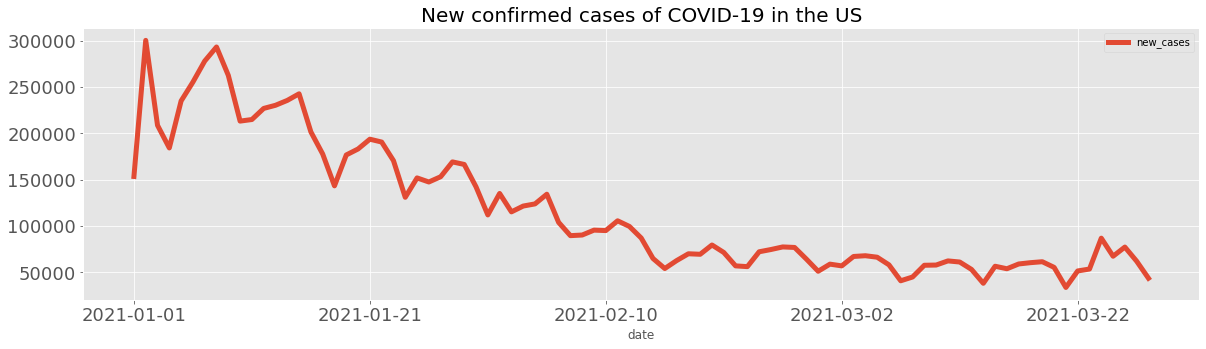

In [776]:
df = pd.DataFrame(us,columns=['date','new_cases'])
df.plot(x ='date', y='new_cases', kind = 'line', figsize = (20,5), fontsize = 18, lw = 5)
plt.title('New confirmed cases of COVID-19 in the US', fontsize = 20) 
plt.show()

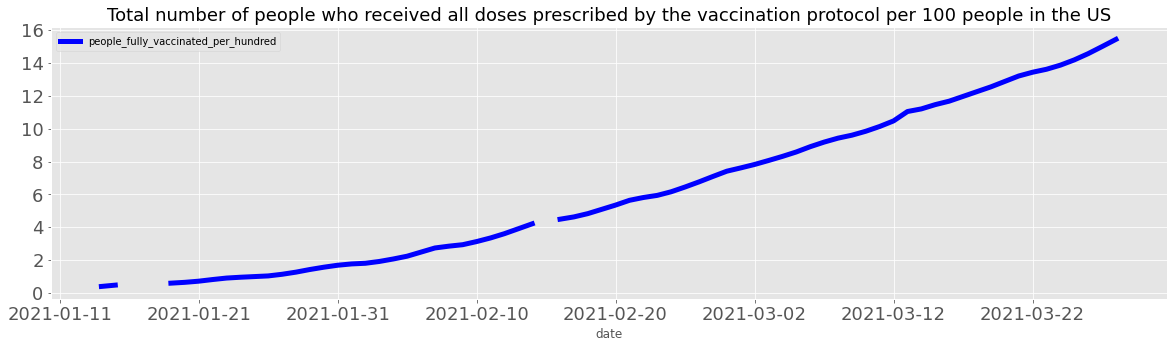

In [777]:
df = pd.DataFrame(us,columns=['date','people_fully_vaccinated_per_hundred'])
df.plot(x ='date', y='people_fully_vaccinated_per_hundred', kind = 'line', figsize = (20,5), fontsize = 18, color='blue', lw = 5)
plt.title('Total number of people who received all doses prescribed by the vaccination protocol per 100 people in the US', fontsize = 18) 
plt.show()

### Explore how vaccination affects the case decrease rate

In [778]:
data.tail(2)

,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,new_cases_per_million,reproduction_rate,icu_patients,...,people_fully_vaccinated_per_hundred,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,handwashing_facilities,hospital_beds_per_thousand
77952,Africa,Zimbabwe,2021-03-27,36818.0,13.0,1519.0,1.0,0.875,NaN,NaN,...,NaN,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,36.791,1.7
77953,Africa,Zimbabwe,2021-03-28,36822.0,4.0,1520.0,1.0,0.269,NaN,NaN,...,NaN,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,36.791,1.7


In [779]:
min_max = data[(data['date'] == '2021-01-01') | (data['date'] == '2021-03-28')]
min_max.head(2)

,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,new_cases_per_million,reproduction_rate,icu_patients,...,people_fully_vaccinated_per_hundred,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,handwashing_facilities,hospital_beds_per_thousand
312,Asia,Afghanistan,2021-01-01,51526.0,0.0,2191.0,0.0,0.000,0.54,NaN,...,NaN,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,37.746,0.5
398,Asia,Afghanistan,2021-03-28,56294.0,4.0,2470.0,1.0,0.103,NaN,NaN,...,NaN,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,37.746,0.5


In [780]:
top_10 = data[(data['date'] == '2021-03-28')].sort_values(by=['people_fully_vaccinated_per_hundred'], ascending=False).head(12)
top_10.drop(top_10.index[0], inplace=True)
top_10.drop(top_10.index[5], inplace=True)
top_10.head(1)

,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,new_cases_per_million,reproduction_rate,icu_patients,...,people_fully_vaccinated_per_hundred,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,handwashing_facilities,hospital_beds_per_thousand
34851,Asia,Israel,2021-03-28,831924.0,541.0,6185.0,20.0,62.503,NaN,NaN,...,54.45,8655541.0,402.606,30.6,11.733,7.359,33132.32,0.5,NaN,2.99


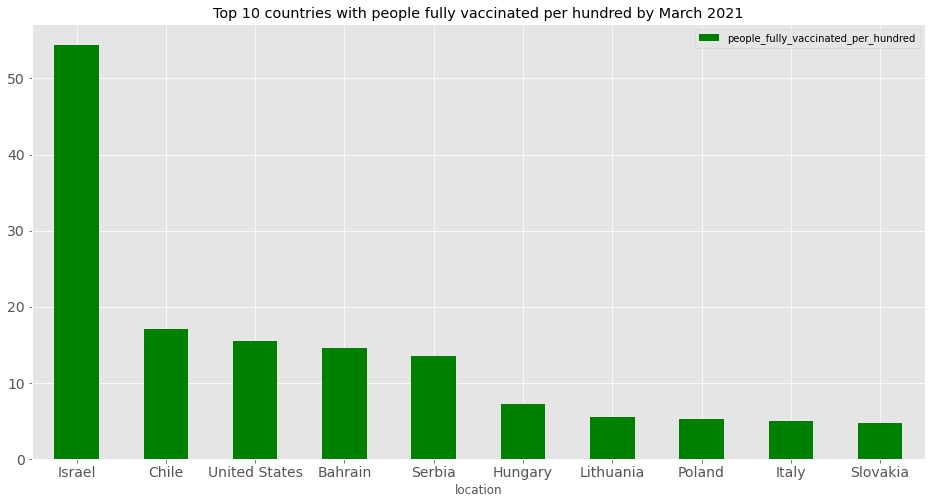

In [781]:
people = pd.Series(top_10['people_fully_vaccinated_per_hundred']).array
index = top_10['location']
df = pd.DataFrame({'people_fully_vaccinated_per_hundred': people}, index=index)
title = 'Top 10 countries with people fully vaccinated per hundred by March 2021'
ax = df.plot.bar(figsize = (16,8), rot=0, title=title, fontsize = 14, color='green')

### Top 10 countries new cases change

In [782]:
a = data[data.date >= '2021-01-01']
df2 = a[a.location == 'Israel']
df3 = a[a.location == 'Chile']
df4 = a[a.location == 'United States']

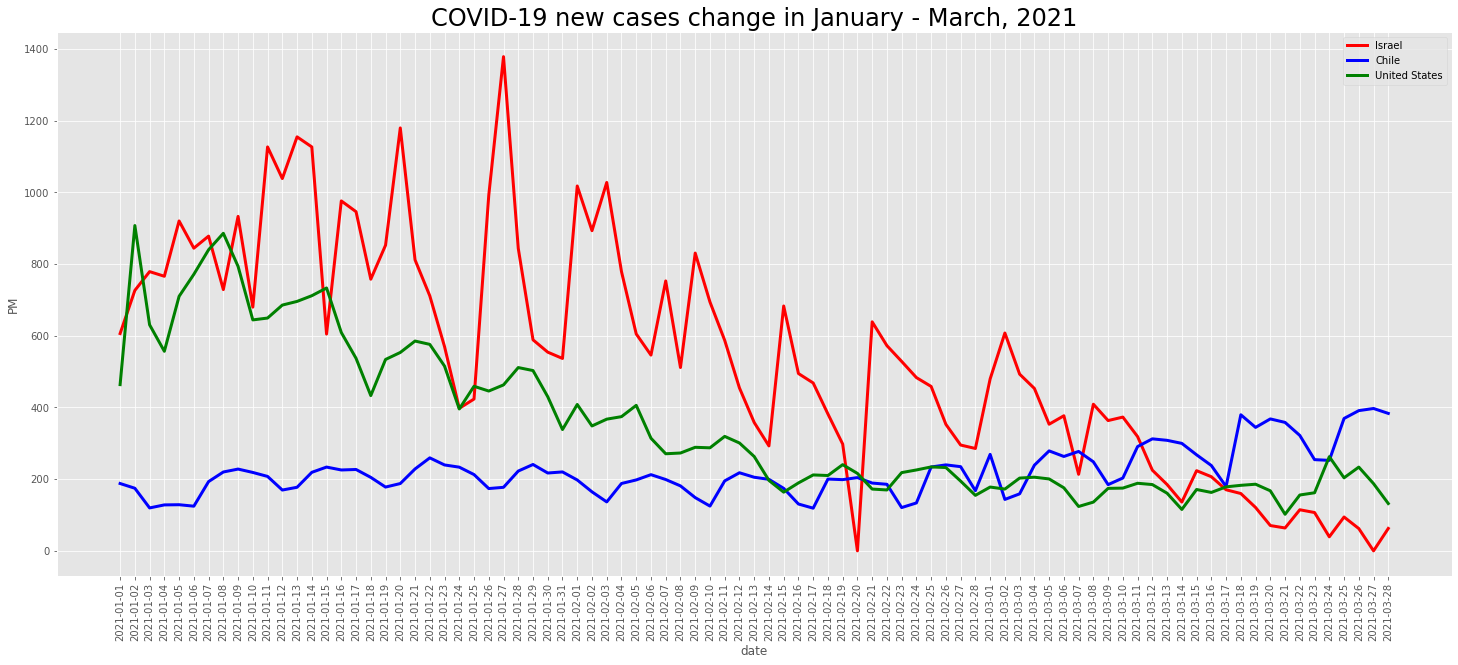

In [783]:
plt.figure(figsize=(25,10))
plt.plot(df2['date'], df2['new_cases_per_million'], label='Israel', color='red', lw=3)
plt.plot(df3['date'], df3['new_cases_per_million'], label='Chile', color='blue', lw=3)
plt.plot(df4['date'], df4['new_cases_per_million'], label='United States', color='green', lw=3)

plt.tick_params(axis='y', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('PM')
plt.xlabel('date')
plt.legend(loc="best")
plt.title('COVID-19 new cases change in January - March, 2021', fontsize = 24)
plt.xticks(rotation = 90)

plt.show()